In [1]:
!pip3 install xgboost

In [2]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install graphviz

Note: you may need to restart the kernel to use updated packages.


# IMPORTANDO LIBRERÍAS

In [4]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
#import plotly.plotly as py

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb

from itertools import product
import itertools
from collections import OrderedDict
import operator
import re
from math import sqrt
import pickle

# DATAFRAME

In [5]:
fifasup=pd.read_csv('prediction.csv')
fifasup.head()

,ID,Name,Position,Age,Height(cm),Weight(kgs),Preferred Foot,Weak Foot,Nationality,Continent,...,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB
0,158023,L. Messi,RF,31,173.727522,72.137028,Left,4.0,Argentina,America,...,64,61,61,61,64,59,47,47,47,59
1,20801,Cristiano Ronaldo,ST,33,188.966778,83.025636,Right,4.0,Portugal,Europe,...,65,61,61,61,65,61,53,53,53,61
2,190871,Neymar Jr,LW,26,179.823225,68.053800,Right,5.0,Brazil,America,...,65,60,60,60,65,60,47,47,47,60
3,193080,De Gea,GK,27,195.062481,76.220256,Right,3.0,Spain,Europe,...,50,50,50,50,50,50,50,50,50,50
4,192985,K. De Bruyne,RCM,27,155.745200,69.868568,Right,5.0,Belgium,Europe,...,77,77,77,77,77,73,66,66,66,73


# AGRUPACIÓN DE DATOS

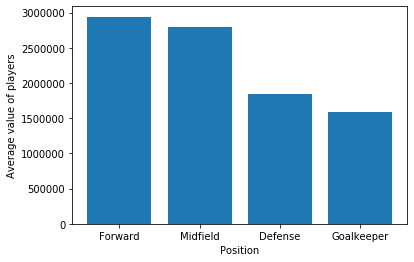

In [6]:
#Player value per position
positions = {
    'Forward' : ['CF', 'LF', 'LS', 'LW', 'RF', 'RS', 'RW', 'ST'],
    'Midfield' : ['CAM', 'CDM', 'CM', 'LAM', 'LCM', 'LDM', 'LM', 'RAM', 'RCB', 'RCM', 'RDM', 'RM'],
    'Defense' : ['CB', 'LB', 'LCB', 'LWB', 'RB', 'RCB', 'RWB'],
    'Goalkeeper' : ['GK'],
}
count_position = {'Forward': 0, 'Midfield': 0, 'Defense': 0, 'Goalkeeper': 0}
players_position = {'Forward': 0, 'Midfield': 0, 'Defense': 0, 'Goalkeeper': 0}
position_avg = {'Forward': 0, 'Midfield': 0, 'Defense': 0, 'Goalkeeper': 0}

def add_values(series):
    already_counted = [0, 0, 0, 0]
    preferred_position_list = re.sub("[^\w]", " ",  series[0]).split() #Split the preferred positions
    value = series[1]

    #Count the players per position category
    index = 0
    for preferred_position in preferred_position_list:
        for position in positions:
            if preferred_position in positions[position]:
                if(not already_counted[index]):
                    count_position[position] += value
                    players_position[position] += 1                    
                    already_counted[index] = 1
                    
position_value = fifasup[['Position', 'Value(€M)']]
position_value.apply(add_values, 1)

#Average the players value per position category
for position in count_position:
    position_avg[position] = count_position[position] / players_position[position]

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)
ax.bar(range(len(position_avg)), list(position_avg.values()))
plt.xticks(range(len(position_avg)), list(position_avg.keys()))
plt.xlabel('Position')
plt.ylabel('Average value of players')
plt.show()

Como podemos observar, las posiciones con mayor cantidad de jugadores son **Delanteros** y **Mediocampistas**.

# MODELOS PREDICTIVOS

Estableceremos un modelo de machine learning para intentar predecir el **valor de mercado** de una jugadora y el **salario** que debería de recibir con base en sus características individuales.

Es importante mencionar que la **nacionalidad** y el **club** son variables que por sí solas genera una brecha salarial y mercado.

In [7]:
fifasup_mach = fifasup.copy()
fifasup_mach = fifasup_mach.drop(['Name', 'Nationality', 'Club','Work Rate','Work RAttack',
                                 'Work RDefense','Contract_Expiry','Preferred Foot', 'Joined',
                                 'Evolution', 'Continent', 'year_joined', 'month_joined',
                                 'day_joined', 'Jersey'], axis = 1)
fifasup_mach = fifasup_mach.drop(fifasup_mach.columns[0], axis = 1)

In [8]:
fifaw_value=pd.read_csv('wdata.csv')
fifaw_value.head()

,ID,Name,Position,Age,Height(cm),Weight(kgs),Preferred Foot,Weak Foot,Nationality,Continent,...,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB
0,190101,Samantha Kerr,ST,26,167,55,Right,4,Australia,Oceania,...,61,74,57,82,26,76,51,57,99,32
1,190102,Megan Rapinoe,CM,34,170,60,Right,4,USA,America,...,64,61,61,61,64,59,47,47,47,59
2,190103,Eugénie Le Sommer,ST,30,161,58,Right,5,France,Europe,...,9,95,11,77,31,76,28,23,85,64
3,190104,Lieke Martens,CM,26,170,66,Right,4,Netherlands,Europe,...,70,67,67,67,70,67,61,61,61,67
4,190105,Alex Morgan,ST,40,170,62,Left,4,USA,America,...,60,58,58,58,60,57,54,54,54,57


In [9]:
fifaw_value = fifaw_value.copy()
fifaw_value = fifaw_value.drop(['Name', 'Nationality', 'Club','Work Rate','Work RAttack',
                                 'Work RDefense','Contract_Expiry','Preferred Foot', 'Joined',
                                 'Evolution', 'Continent', 'year_joined', 'month_joined',
                                 'day_joined', 'Jersey'], axis = 1)
fifaw_value = fifaw_value.drop(fifaw_value.columns[0], axis = 1)

In [10]:
fifaw_wage=pd.read_csv('wdata.csv')
fifaw_wage.head()

,ID,Name,Position,Age,Height(cm),Weight(kgs),Preferred Foot,Weak Foot,Nationality,Continent,...,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB
0,190101,Samantha Kerr,ST,26,167,55,Right,4,Australia,Oceania,...,61,74,57,82,26,76,51,57,99,32
1,190102,Megan Rapinoe,CM,34,170,60,Right,4,USA,America,...,64,61,61,61,64,59,47,47,47,59
2,190103,Eugénie Le Sommer,ST,30,161,58,Right,5,France,Europe,...,9,95,11,77,31,76,28,23,85,64
3,190104,Lieke Martens,CM,26,170,66,Right,4,Netherlands,Europe,...,70,67,67,67,70,67,61,61,61,67
4,190105,Alex Morgan,ST,40,170,62,Left,4,USA,America,...,60,58,58,58,60,57,54,54,54,57


In [11]:
fifaw_wage = fifaw_wage.copy()
fifaw_wage = fifaw_wage.drop(['Name', 'Nationality', 'Club','Work Rate','Work RAttack',
                                 'Work RDefense','Contract_Expiry','Preferred Foot', 'Joined',
                                 'Evolution', 'Continent', 'year_joined', 'month_joined',
                                 'day_joined', 'Jersey'], axis = 1)
fifaw_wage = fifaw_wage.drop(fifaw_wage.columns[0], axis = 1)

In [12]:
y_valuew = fifaw_value['Value(€M)'].copy()
fifaw_value = fifaw_value.drop(['Value(€M)', 'Wage(€K)'], axis = 1)

In [13]:
y_wagew = fifaw_wage['Wage(€K)'].copy()
fifaw_wage = fifaw_wage.drop(['Value(€M)', 'Wage(€K)'], axis = 1)

In [14]:
y_value = fifasup_mach['Value(€M)'].copy()
y_wage = fifasup_mach['Wage(€K)'].copy()
fifasup_mach = fifasup_mach.drop(['Value(€M)', 'Wage(€K)'], axis = 1)

In [15]:
def count_positions(position):
    return len(re.sub("[^\w]", " ",  position).split())

In [16]:
fifasup_mach['Versatility'] = fifasup_mach['Position'].apply(count_positions)
fifasup_mach.head()

,Position,Age,Height(cm),Weight(kgs),Weak Foot,Inter_Rep,Overall,Potential,Difference,Release_Clause(€M),...,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Versatility
0,RF,31,173.727522,72.137028,4.0,5.0,94,94,0,226500000.0,...,61,61,61,64,59,47,47,47,59,1
1,ST,33,188.966778,83.025636,4.0,5.0,94,94,0,127100000.0,...,61,61,61,65,61,53,53,53,61,1
2,LW,26,179.823225,68.053800,5.0,5.0,92,93,1,228100000.0,...,60,60,60,65,60,47,47,47,60,1
3,GK,27,195.062481,76.220256,3.0,4.0,91,93,2,138600000.0,...,50,50,50,50,50,50,50,50,50,1
4,RCM,27,155.745200,69.868568,5.0,4.0,91,92,1,196400000.0,...,77,77,77,77,73,66,66,66,73,1


In [17]:
fifaw_value['Versatility'] = fifaw_value['Position'].apply(count_positions)
fifaw_value.head()

,Position,Age,Height(cm),Weight(kgs),Weak Foot,Inter_Rep,Overall,Potential,Difference,Release_Clause(€M),...,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Versatility
0,ST,26,167,55,4,4,92,95,3,200000,...,74,57,82,26,76,51,57,99,32,1
1,CM,34,170,60,4,5,92,92,0,200000,...,61,61,61,64,59,47,47,47,59,1
2,ST,30,161,58,5,3,91,91,2,200000,...,95,11,77,31,76,28,23,85,64,1
3,CM,26,170,66,4,4,90,91,1,200000,...,67,67,67,70,67,61,61,61,67,1
4,ST,40,170,62,4,3,90,92,2,200000,...,58,58,58,60,57,54,54,54,57,1


In [18]:
fifaw_wage['Versatility'] = fifaw_wage['Position'].apply(count_positions)
fifaw_wage.head()

,Position,Age,Height(cm),Weight(kgs),Weak Foot,Inter_Rep,Overall,Potential,Difference,Release_Clause(€M),...,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Versatility
0,ST,26,167,55,4,4,92,95,3,200000,...,74,57,82,26,76,51,57,99,32,1
1,CM,34,170,60,4,5,92,92,0,200000,...,61,61,61,64,59,47,47,47,59,1
2,ST,30,161,58,5,3,91,91,2,200000,...,95,11,77,31,76,28,23,85,64,1
3,CM,26,170,66,4,4,90,91,1,200000,...,67,67,67,70,67,61,61,61,67,1
4,ST,40,170,62,4,3,90,92,2,200000,...,58,58,58,60,57,54,54,54,57,1


In [19]:
fifasup_mach['Versatility'].unique()

array([1])

In [20]:
fifasup_mach = fifasup_mach.drop(['Position'], axis = 1)

In [21]:
fifaw_value = fifaw_value.drop(['Position'], axis = 1)

In [22]:
fifaw_wage = fifaw_wage.drop(['Position'], axis = 1)

**Boosting** aplica un proceso iterativo donde en lugar de entrenar a todos los modelos de forma aislada cada nuevo modelo se entrena para corregir los errores cometidos por los anteriores. Es decir, los modelos se van agregando de forma secuencialmente hasta que no se puedan realizar más mejoras.

Empezaremos por crear un train-test-split donde el entrenamiento tome el 80% de los datos y el test el restante 20%.

**XGBoost** requiere que la información se presente de una forma particular denominada **DMatrix**. Es una transformación linear de los datos, pero es requerida.

Los parámetros más simples son **max_depth** (profundidad máxima de los árboles de decisión que se están entrenando), **objective** (la función de pérdida utilizada) y **num_class** (el número de clases en el conjunto de datos). El parámetro **eta** tiene una interpretación especial.


**Gradient Boosting** implica crear y agregar árboles de decisión a un modelo de conjunto secuencialmente. Se crean nuevos árboles para corregir los errores residuales en las predicciones del conjunto existente. Tener varios modelos juntos para formar uno muy grande y complicado puede generar que esta técnica sea propensa al **overfitting**. El parámetro **eta** nos permite evitar este problema, ya que se puede considerarlo como una tasa de aprendizaje. 

En lugar de simplemente agregar las predicciones de nuevos árboles al conjunto con todo el peso, el eta se multiplicará por los residuos que se agregan para reducir su peso. Esto reduce efectivamente la complejidad del modelo general.

Es común tener valores pequeños en el rango de **0.1 a 0.3**. La menor ponderación de estos residuos todavía nos ayudará a entrenar un modelo poderoso, pero no permitirá que ese modelo se escape a una complejidad profunda donde es más probable que ocurra un **overfitting**.

La información para adaptar mi modelo https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f 

# MODELO 1: Predicción del valor de mercado

In [23]:
X_train_value, X_test_value, y_train_value, y_test_value = train_test_split(fifasup_mach, y_value, test_size=0.2)

In [24]:
num_boost_round = 999
early_stopping_rounds = 10

xgb_params = {
                'n_estimators':[500],
                'objective':['reg:linear'],
                'eval_metric':[ ["rmse" ,"mae"]],
                'min_child_weight': [1],
                'eta': [0.01, 0.1], 
                'gamma': [0.05, 0.1],  
                'subsample': [0.8, 1.0],
                'colsample_bytree': [0.8, 1.0],
               'max_depth': [6, 9]
              }

params_perms = [dict(zip(xgb_params, v)) for v in product(*xgb_params.values())]
print(len(params_perms))
print(params_perms[0])

32
{'n_estimators': 500, 'objective': 'reg:linear', 'eval_metric': ['rmse', 'mae'], 'min_child_weight': 1, 'eta': 0.01, 'gamma': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.8, 'max_depth': 6}


In [25]:
dtrain_value = xgb.DMatrix(X_train_value, label=y_train_value)
dtest_value = xgb.DMatrix(X_test_value, label=y_test_value)
evaluation_set_value = [(dtest_value, "Test_set")]

In [26]:
mean_train_value = np.mean(y_train_value)

baseline_predictions_value = np.ones(y_test_value.shape) * mean_train_value

mae_baseline_value = mean_absolute_error(y_test_value, baseline_predictions_value)

rmse_baseline_value = sqrt(mean_squared_error(y_test_value, baseline_predictions_value))

print("Baseline MAE is {:.2f}".format(mae_baseline_value))
print("Baseline RMSE is {:.2f}".format(rmse_baseline_value))

Baseline MAE is 2789603.61
Baseline RMSE is 5839010.42


In [27]:
best_score_value = mae_baseline_value
best_params_value = {}
for i, grid_search_value in enumerate(params_perms):
    print("Permutation number:", i+1)
    cv_results_value = xgb.cv(grid_search_value,
                        dtrain_value,
                       num_boost_round=num_boost_round,
                      seed=42,
                     nfold=2,
                    metrics=['mae', 'rmse'],
                   early_stopping_rounds=early_stopping_rounds
                  )
    
    mean_mae_value = cv_results_value['test-mae-mean'].min()
    boost_rounds_value = cv_results_value['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae_value, boost_rounds_value))
    if mean_mae_value < best_score_value:
        best_score_value = mean_mae_value
        best_params_value = grid_search_value

Permutation number: 1
[11:39:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:39:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 183331.4140625 for 998 rounds
Permutation number: 2
[11:41:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:41:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 172158.4375 for 998 rounds
Permutation number: 3
[11:43:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:43:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 184851.9921875 for 998 rounds
Permutation number: 4
[11:44:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror

	MAE 190022.984375 for 105 rounds
Permutation number: 30
[12:12:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:12:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 179175.328125 for 198 rounds
Permutation number: 31
[12:13:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:13:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 186391.6484375 for 142 rounds
Permutation number: 32
[12:13:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:13:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 174779.1171875 for 172 rounds


In [28]:
print("Best Score:", best_score_value)
print("Best Parameters:", best_params_value)

Best Score: 171512.3515625
Best Parameters: {'n_estimators': 500, 'objective': 'reg:linear', 'eval_metric': ['rmse', 'mae'], 'min_child_weight': 1, 'eta': 0.01, 'gamma': 0.05, 'subsample': 0.8, 'colsample_bytree': 1.0, 'max_depth': 9}


In [29]:
#Retrain a model with new best params
model_value = xgb.train(
    best_params_value,
    dtrain_value,
    num_boost_round=num_boost_round,
    evals=evaluation_set_value,
    early_stopping_rounds=early_stopping_rounds
 )

[12:13:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	Test_set-rmse:6.28321e+06	Test_set-mae:2.45703e+06
Multiple eval metrics have been passed: 'Test_set-mae' will be used for early stopping.

Will train until Test_set-mae hasn't improved in 10 rounds.
[1]	Test_set-rmse:6.22313e+06	Test_set-mae:2.43265e+06
[2]	Test_set-rmse:6.16375e+06	Test_set-mae:2.40863e+06
[3]	Test_set-rmse:6.10637e+06	Test_set-mae:2.38498e+06
[4]	Test_set-rmse:6.04968e+06	Test_set-mae:2.36171e+06
[5]	Test_set-rmse:5.9929e+06	Test_set-mae:2.33858e+06
[6]	Test_set-rmse:5.93593e+06	Test_set-mae:2.31568e+06
[7]	Test_set-rmse:5.88051e+06	Test_set-mae:2.29318e+06
[8]	Test_set-rmse:5.82552e+06	Test_set-mae:2.27081e+06
[9]	Test_set-rmse:5.7713e+06	Test_set-mae:2.24874e+06
[10]	Test_set-rmse:5.71766e+06	Test_set-mae:2.22694e+06
[11]	Test_set-rmse:5.66291e+06	Test_set-mae:2.20504e+06
[12]	Test_set-rmse:5.60911e+06	Test_set-mae:2.18353e+06
[13]	Test_set-rmse:

[146]	Test_set-rmse:1.65731e+06	Test_set-mae:615076
[147]	Test_set-rmse:1.64499e+06	Test_set-mae:609594
[148]	Test_set-rmse:1.63024e+06	Test_set-mae:604011
[149]	Test_set-rmse:1.61748e+06	Test_set-mae:598637
[150]	Test_set-rmse:1.60432e+06	Test_set-mae:593303
[151]	Test_set-rmse:1.59064e+06	Test_set-mae:587913
[152]	Test_set-rmse:1.57855e+06	Test_set-mae:582665
[153]	Test_set-rmse:1.56599e+06	Test_set-mae:577526
[154]	Test_set-rmse:1.55317e+06	Test_set-mae:572378
[155]	Test_set-rmse:1.54136e+06	Test_set-mae:567355
[156]	Test_set-rmse:1.52939e+06	Test_set-mae:562275
[157]	Test_set-rmse:1.51841e+06	Test_set-mae:557378
[158]	Test_set-rmse:1.50622e+06	Test_set-mae:552408
[159]	Test_set-rmse:1.49349e+06	Test_set-mae:547461
[160]	Test_set-rmse:1.48241e+06	Test_set-mae:542688
[161]	Test_set-rmse:1.47049e+06	Test_set-mae:537810
[162]	Test_set-rmse:1.45941e+06	Test_set-mae:533043
[163]	Test_set-rmse:1.44745e+06	Test_set-mae:528253
[164]	Test_set-rmse:1.43615e+06	Test_set-mae:523536
[165]	Test_s

[313]	Test_set-rmse:716089	Test_set-mae:201253
[314]	Test_set-rmse:715173	Test_set-mae:200658
[315]	Test_set-rmse:714359	Test_set-mae:200080
[316]	Test_set-rmse:712944	Test_set-mae:199460
[317]	Test_set-rmse:711685	Test_set-mae:198912
[318]	Test_set-rmse:710736	Test_set-mae:198387
[319]	Test_set-rmse:710227	Test_set-mae:197864
[320]	Test_set-rmse:709132	Test_set-mae:197317
[321]	Test_set-rmse:708199	Test_set-mae:196786
[322]	Test_set-rmse:707465	Test_set-mae:196318
[323]	Test_set-rmse:706346	Test_set-mae:195779
[324]	Test_set-rmse:705566	Test_set-mae:195279
[325]	Test_set-rmse:704693	Test_set-mae:194749
[326]	Test_set-rmse:703705	Test_set-mae:194253
[327]	Test_set-rmse:702629	Test_set-mae:193756
[328]	Test_set-rmse:701751	Test_set-mae:193247
[329]	Test_set-rmse:700899	Test_set-mae:192793
[330]	Test_set-rmse:700309	Test_set-mae:192343
[331]	Test_set-rmse:699441	Test_set-mae:191864
[332]	Test_set-rmse:698694	Test_set-mae:191418
[333]	Test_set-rmse:698135	Test_set-mae:190982
[334]	Test_se

[488]	Test_set-rmse:654815	Test_set-mae:167526
[489]	Test_set-rmse:654957	Test_set-mae:167486
[490]	Test_set-rmse:654860	Test_set-mae:167447
[491]	Test_set-rmse:654772	Test_set-mae:167405
[492]	Test_set-rmse:654586	Test_set-mae:167348
[493]	Test_set-rmse:654503	Test_set-mae:167317
[494]	Test_set-rmse:654391	Test_set-mae:167274
[495]	Test_set-rmse:654316	Test_set-mae:167231
[496]	Test_set-rmse:654265	Test_set-mae:167214
[497]	Test_set-rmse:654110	Test_set-mae:167180
[498]	Test_set-rmse:653996	Test_set-mae:167161
[499]	Test_set-rmse:653936	Test_set-mae:167137
[500]	Test_set-rmse:653781	Test_set-mae:167096
[501]	Test_set-rmse:653764	Test_set-mae:167065
[502]	Test_set-rmse:653724	Test_set-mae:167031
[503]	Test_set-rmse:653643	Test_set-mae:166998
[504]	Test_set-rmse:653432	Test_set-mae:166939
[505]	Test_set-rmse:653550	Test_set-mae:166912
[506]	Test_set-rmse:653553	Test_set-mae:166895
[507]	Test_set-rmse:653452	Test_set-mae:166856
[508]	Test_set-rmse:653583	Test_set-mae:166839
[509]	Test_se

[663]	Test_set-rmse:653960	Test_set-mae:165025
[664]	Test_set-rmse:654025	Test_set-mae:165033
[665]	Test_set-rmse:654056	Test_set-mae:165025
[666]	Test_set-rmse:654049	Test_set-mae:165020
[667]	Test_set-rmse:654048	Test_set-mae:165007
[668]	Test_set-rmse:654027	Test_set-mae:165005
[669]	Test_set-rmse:654063	Test_set-mae:165006
[670]	Test_set-rmse:654055	Test_set-mae:164998
[671]	Test_set-rmse:654031	Test_set-mae:164987
[672]	Test_set-rmse:653997	Test_set-mae:164980
[673]	Test_set-rmse:654010	Test_set-mae:164967
[674]	Test_set-rmse:654040	Test_set-mae:164962
[675]	Test_set-rmse:654030	Test_set-mae:164955
[676]	Test_set-rmse:654019	Test_set-mae:164954
[677]	Test_set-rmse:654039	Test_set-mae:164967
[678]	Test_set-rmse:654040	Test_set-mae:164957
[679]	Test_set-rmse:653982	Test_set-mae:164939
[680]	Test_set-rmse:654011	Test_set-mae:164941
[681]	Test_set-rmse:653998	Test_set-mae:164932
[682]	Test_set-rmse:653986	Test_set-mae:164917
[683]	Test_set-rmse:653964	Test_set-mae:164913
[684]	Test_se

[838]	Test_set-rmse:653391	Test_set-mae:164064
[839]	Test_set-rmse:653371	Test_set-mae:164050
[840]	Test_set-rmse:653352	Test_set-mae:164046
[841]	Test_set-rmse:653342	Test_set-mae:164047
[842]	Test_set-rmse:653363	Test_set-mae:164024
[843]	Test_set-rmse:653344	Test_set-mae:164015
[844]	Test_set-rmse:653331	Test_set-mae:164006
[845]	Test_set-rmse:653323	Test_set-mae:164002
[846]	Test_set-rmse:653318	Test_set-mae:163996
[847]	Test_set-rmse:653320	Test_set-mae:163998
[848]	Test_set-rmse:653318	Test_set-mae:163997
[849]	Test_set-rmse:653323	Test_set-mae:163988
[850]	Test_set-rmse:653320	Test_set-mae:163988
[851]	Test_set-rmse:653312	Test_set-mae:163987
[852]	Test_set-rmse:653300	Test_set-mae:163982
[853]	Test_set-rmse:653295	Test_set-mae:163984
[854]	Test_set-rmse:653282	Test_set-mae:163983
[855]	Test_set-rmse:653267	Test_set-mae:163974
[856]	Test_set-rmse:653251	Test_set-mae:163974
[857]	Test_set-rmse:653258	Test_set-mae:163971
[858]	Test_set-rmse:653253	Test_set-mae:163970
[859]	Test_se

In [30]:
print("Average guess error", mae_baseline_value)
print("vs Mean Absolute Error", mean_absolute_error(model_value.predict(dtest_value), y_test_value))

Average guess error 2789603.6135236523
vs Mean Absolute Error 163250.44718893722


In [31]:
#!#Predict the value based on the model.
dpred_value = xgb.DMatrix(fifasup_mach, label = y_value)
y_pred = pd.Series(model_value.predict(dpred_value))

In [32]:
#!#Top 10% players with overpriced transfer values.
sub_value = y_value.subtract(y_pred)
exp_value = fifasup_mach.loc[sub_value.nlargest(int(len(sub_value)/1000)).index]
exp_value

,Age,Height(cm),Weight(kgs),Weak Foot,Inter_Rep,Overall,Potential,Difference,Release_Clause(€M),Special,...,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Versatility
5,27,176.775373,73.951796,4.0,4.0,91,91,0,172100000.0,2142,...,63,63,63,66,60,49,49,49,60,1
29,27,164.583968,58.979960,3.0,3.0,88,88,0,105400000.0,2017,...,58,58,58,63,58,44,44,44,58,1
72,28,155.440415,72.137028,4.0,3.0,86,86,0,72600000.0,2182,...,80,80,80,78,76,73,73,73,76,1
14,27,170.679671,72.137028,3.0,3.0,89,90,1,121300000.0,2189,...,87,87,87,85,84,83,83,83,84,1
78,23,192.014630,76.220256,4.0,2.0,85,90,5,89600000.0,2206,...,80,80,80,77,76,79,79,79,76,1
444,24,188.966778,83.933020,4.0,3.0,80,85,5,200000.0,2065,...,77,77,77,72,71,74,74,74,71,1
702,29,182.871076,79.849792,3.0,2.0,79,79,0,200000.0,1172,...,50,50,50,50,50,50,50,50,50,1
226,18,188.966778,88.923632,4.0,2.0,82,91,9,43200000.0,1937,...,77,77,77,73,75,80,80,80,75,1
329,22,179.823225,69.868568,4.0,3.0,81,86,5,35400000.0,2019,...,59,59,59,64,60,52,52,52,60,1
245,23,192.014630,83.933020,3.0,2.0,82,86,4,42300000.0,1705,...,74,74,74,70,73,80,80,80,73,1


In [33]:
#Top 10% players with underpriced transfer values.
cheap_value = sub_value.nsmallest(int(len(sub_value)/1000))
cheap_value = fifasup_mach.loc[cheap_value.index]
cheap_value

,Age,Height(cm),Weight(kgs),Weak Foot,Inter_Rep,Overall,Potential,Difference,Release_Clause(€M),Special,...,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Versatility
41,40,195.062481,92.099476,2.0,4.0,88,88,0,7400000.0,1334,...,50,50,50,50,50,50,50,50,50,1
1964,26,182.871076,78.942408,3.0,1.0,75,78,3,200000.0,1868,...,60,60,60,62,58,51,51,51,58,1
2443,23,173.727522,64.877956,5.0,1.0,74,80,6,200000.0,1728,...,49,49,49,54,50,38,38,38,50,1
32,26,176.775373,68.053800,4.0,3.0,88,89,1,147700000.0,2175,...,70,70,70,71,67,58,58,58,67,1
1352,31,155.440415,72.137028,4.0,3.0,76,76,0,200000.0,1926,...,54,54,54,57,52,43,43,43,52,1
17,27,179.823225,73.044412,3.0,4.0,89,90,1,165800000.0,2246,...,67,67,67,70,67,61,61,61,67,1
953,30,188.966778,71.229644,3.0,1.0,77,77,0,200000.0,1749,...,72,72,72,67,69,75,75,75,69,1
2452,28,173.727522,74.859180,3.0,1.0,74,74,0,200000.0,1817,...,59,59,59,61,58,51,51,51,58,1
538,33,195.062481,83.933020,4.0,2.0,80,80,0,200000.0,1797,...,74,74,74,68,70,79,79,79,70,1
30,26,179.823225,78.942408,3.0,3.0,88,91,3,156200000.0,2137,...,73,73,73,72,68,63,63,63,68,1


In [34]:
model_value.save_model("model_value.model")

In [35]:
fifasup_mach.columns

Index(['Age', 'Height(cm)', 'Weight(kgs)', 'Weak Foot', 'Inter_Rep', 'Overall',
       'Potential', 'Difference', 'Release_Clause(€M)', 'Special',
       'SkillMoves', 'ShortPass', 'LongPass', 'ShotPower', 'LongShots',
       'Penalties', 'Agility', 'Acceleration', 'SprintSpeed', 'Stamina',
       'Strength', 'Reactions', 'Dribbling', 'BallControl', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Balance', 'Composure',
       'Crossing', 'Finishing', 'Jumping', 'HeadAccuracy', 'Marking',
       'StandingTackle', 'SlidingTackle', 'GKDiving', 'Volleys', 'Curve',
       'FKAccuracy', 'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes',
       'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW', 'LAM', 'CAM', 'RAM',
       'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM', 'CDM', 'RDM', 'RWB', 'LB',
       'LCB', 'CB', 'RCB', 'RB', 'Versatility'],
      dtype='object')

In [36]:
fifaw_value.shape

(15, 72)

In [37]:
loaded_modelv = xgb.Booster()
loaded_modelv.load_model("model_value.model")

[12:15:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [38]:
fifaw_value['Value(€M)'] = loaded_modelv.predict(xgb.DMatrix(fifaw_value))

In [39]:
exchange_rate = 21.1473

In [40]:
fifaw_value['Value($M)'] = fifaw_value['Value(€M)'] * exchange_rate

In [41]:
fifaw_value

,Age,Height(cm),Weight(kgs),Weak Foot,Inter_Rep,Overall,Potential,Difference,Release_Clause(€M),Special,...,RDM,RWB,LB,LCB,CB,RCB,RB,Versatility,Value(€M),Value($M)
0,26,167,55,4,4,92,95,3,200000,1598,...,82,26,76,51,57,99,32,1,46675804.0,9.870673e+08
1,34,170,60,4,5,92,92,0,200000,2202,...,61,64,59,47,47,47,59,1,47310668.0,1.000493e+09
2,30,161,58,5,3,91,91,2,200000,1598,...,77,31,76,28,23,85,64,1,49555032.0,1.047955e+09
3,26,170,66,4,4,90,91,1,200000,2246,...,67,70,67,61,61,61,67,1,53769692.0,1.137084e+09
4,40,170,62,4,3,90,92,2,200000,2031,...,58,60,57,54,54,54,57,1,43127496.0,9.120301e+08
5,26,156,52,5,2,88,91,3,200000,1598,...,75,64,43,77,31,11,98,1,45139304.0,9.545745e+08
6,28,160,55,2,3,82,82,0,200000,2154,...,83,78,77,81,81,81,77,1,17948262.0,3.795573e+08
7,28,152,52,4,4,82,84,2,200000,1926,...,53,59,54,42,42,42,54,1,22632936.0,4.786255e+08
8,30,166,57,4,3,83,83,0,200000,1598,...,90,96,60,32,30,36,40,1,20391200.0,4.312188e+08
9,27,175,68,3,4,81,84,3,200000,1598,...,84,35,63,59,38,12,37,1,17689290.0,3.740807e+08


# MODELO 2: Predicción del salario

In [42]:
X_train_wage, X_test_wage, y_train_wage, y_test_wage = train_test_split(fifasup_mach, y_wage, test_size=0.2)

In [43]:
dtrain_wage = xgb.DMatrix(X_train_wage, label=y_train_wage)
dtest_wage = xgb.DMatrix(X_test_wage, label=y_test_wage)
evaluation_set_wage = [(dtest_wage, "Test_set")]

In [44]:
mean_train_wage = np.mean(y_train_wage)

baseline_predictions_wage = np.ones(y_test_wage.shape) * mean_train_wage

mae_baseline_wage = mean_absolute_error(y_test_wage, baseline_predictions_wage)

rmse_baseline_wage = sqrt(mean_squared_error(y_test_wage, baseline_predictions_wage))

print("Baseline MAE is {:.2f}".format(mae_baseline_wage))
print("Baseline RMSE is {:.2f}".format(rmse_baseline_wage))

Baseline MAE is 14535.36
Baseline RMSE is 32249.61


In [45]:
best_score_wage = mae_baseline_wage
best_params_wage = {}
for i, grid_search_wage in enumerate(params_perms):
    print("Permutation number:", i+1)
    cv_results_wage = xgb.cv(grid_search_wage,
                        dtrain_wage,
                        num_boost_round=num_boost_round,
                        seed=42,
                        nfold=2,
                        metrics=['mae', 'rmse'],
                        early_stopping_rounds=early_stopping_rounds
                        )
    
    mean_mae_wage = cv_results_wage['test-mae-mean'].min()
    boost_rounds_wage = cv_results_wage['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae_wage, boost_rounds_wage))
    if mean_mae_wage < best_score_wage:
        best_score_wage = mean_mae_wage
        best_params_wage = grid_search_wage

Permutation number: 1
[12:15:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:15:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 7478.4387205 for 150 rounds
Permutation number: 2
[12:16:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:16:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 7303.6918945 for 172 rounds
Permutation number: 3
[12:17:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:17:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 7554.022217 for 162 rounds
Permutation number: 4
[12:19:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[1

	MAE 7574.373291 for 13 rounds
Permutation number: 30
[12:33:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:33:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 7470.817383 for 16 rounds
Permutation number: 31
[12:33:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:33:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 7592.4675295 for 15 rounds
Permutation number: 32
[12:33:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:33:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 7606.4104005 for 15 rounds


In [46]:
#!#Retrain a model with new best params
model_wage = xgb.train(
    best_params_wage,
    dtrain_wage,
    num_boost_round=num_boost_round,
    evals=evaluation_set_wage,
    early_stopping_rounds=early_stopping_rounds
)

[12:33:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	Test_set-rmse:34425.7	Test_set-mae:12456.8
Multiple eval metrics have been passed: 'Test_set-mae' will be used for early stopping.

Will train until Test_set-mae hasn't improved in 10 rounds.
[1]	Test_set-rmse:34238.6	Test_set-mae:12336.3
[2]	Test_set-rmse:34099.2	Test_set-mae:12226.5
[3]	Test_set-rmse:33972.9	Test_set-mae:12118.4
[4]	Test_set-rmse:33784.1	Test_set-mae:12011.3
[5]	Test_set-rmse:33609.3	Test_set-mae:11907.2
[6]	Test_set-rmse:33448.7	Test_set-mae:11806.5
[7]	Test_set-rmse:33322.3	Test_set-mae:11705.6
[8]	Test_set-rmse:33147.9	Test_set-mae:11606.6
[9]	Test_set-rmse:33025.5	Test_set-mae:11507.6
[10]	Test_set-rmse:32854.2	Test_set-mae:11414.3
[11]	Test_set-rmse:32694.3	Test_set-mae:11326.7
[12]	Test_set-rmse:32530.8	Test_set-mae:11239
[13]	Test_set-rmse:32386.5	Test_set-mae:11153.9
[14]	Test_set-rmse:32243.8	Test_set-mae:11071.3
[15]	Test_set-rmse:32129.9	

[165]	Test_set-rmse:22493.9	Test_set-mae:7356.78
[166]	Test_set-rmse:22480.6	Test_set-mae:7357.62
[167]	Test_set-rmse:22465.6	Test_set-mae:7354.52
[168]	Test_set-rmse:22446.5	Test_set-mae:7354.5
[169]	Test_set-rmse:22432.2	Test_set-mae:7352.35
[170]	Test_set-rmse:22407	Test_set-mae:7350
[171]	Test_set-rmse:22392.2	Test_set-mae:7347.46
[172]	Test_set-rmse:22369.6	Test_set-mae:7346.68
[173]	Test_set-rmse:22354.2	Test_set-mae:7347.86
[174]	Test_set-rmse:22341.6	Test_set-mae:7347.24
[175]	Test_set-rmse:22328.5	Test_set-mae:7346.55
[176]	Test_set-rmse:22312.6	Test_set-mae:7347.06
[177]	Test_set-rmse:22302	Test_set-mae:7347.06
[178]	Test_set-rmse:22289.2	Test_set-mae:7349.53
[179]	Test_set-rmse:22273.9	Test_set-mae:7348.36
[180]	Test_set-rmse:22260.4	Test_set-mae:7348.5
[181]	Test_set-rmse:22252.7	Test_set-mae:7349.64
[182]	Test_set-rmse:22234.6	Test_set-mae:7349.5
[183]	Test_set-rmse:22223.5	Test_set-mae:7349.3
[184]	Test_set-rmse:22203.5	Test_set-mae:7347.21
[185]	Test_set-rmse:22186.7	Tes

In [47]:
print("Average guess error", mae_baseline_wage)
print("vs Mean Absolute Error", mean_absolute_error(model_wage.predict(dtest_wage), y_test_wage))

Average guess error 14535.359641577184
vs Mean Absolute Error 7346.8963366303715


In [48]:
#!#Predict the value based on the model.
dpred_wage = xgb.DMatrix(fifasup_mach, label = y_wage)
y_pred_wage = pd.Series(model_wage.predict(dpred_wage))

In [49]:
#!#Top 10% players with overpriced wages.
sub_wage = y_value.subtract(y_pred_wage)
exp_wage = fifasup_mach.loc[sub_wage.nlargest(int(len(sub_wage)/1000)).index]
exp_wage

,Age,Height(cm),Weight(kgs),Weak Foot,Inter_Rep,Overall,Potential,Difference,Release_Clause(€M),Special,...,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Versatility
2,26,179.823225,68.053800,5.0,5.0,92,93,1,228100000.0,2143,...,60,60,60,65,60,47,47,47,60,1
0,31,173.727522,72.137028,4.0,5.0,94,94,0,226500000.0,2202,...,61,61,61,64,59,47,47,47,59,1
4,27,155.745200,69.868568,5.0,4.0,91,92,1,196400000.0,2281,...,77,77,77,77,73,66,66,66,73,1
5,27,176.775373,73.951796,4.0,4.0,91,91,0,172100000.0,2142,...,63,63,63,66,60,49,49,49,60,1
15,24,155.440415,74.859180,3.0,3.0,89,94,5,153500000.0,2092,...,58,58,58,62,56,45,45,45,56,1
16,24,188.966778,88.923632,4.0,3.0,89,91,2,160700000.0,2165,...,66,66,66,65,62,60,60,60,62,1
25,19,155.440415,73.044412,4.0,3.0,88,95,7,166100000.0,2118,...,62,62,62,66,62,54,54,54,62,1
7,31,182.871076,86.201480,4.0,5.0,91,91,0,164000000.0,2346,...,68,68,68,69,66,63,63,63,66,1
17,27,179.823225,73.044412,3.0,4.0,89,90,1,165800000.0,2246,...,67,67,67,70,67,61,61,61,67,1
10,29,182.871076,79.849792,4.0,4.0,90,90,0,127100000.0,2152,...,62,62,62,61,58,57,57,57,58,1


In [50]:
#!#Top 10% players with underpriced transfer values.
cheap_wage = sub_wage.nsmallest(int(len(sub_wage)/1000))
cheap_wage = fifasup_mach.loc[cheap_wage.index]
cheap_wage

,Age,Height(cm),Weight(kgs),Weak Foot,Inter_Rep,Overall,Potential,Difference,Release_Clause(€M),Special,...,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Versatility
16628,38,188.966778,79.849792,2.0,1.0,57,57,0,13000.0,1001,...,50,50,50,50,50,50,50,50,50,1
16310,36,188.966778,83.933020,2.0,1.0,57,57,0,18000.0,1117,...,50,50,50,50,50,50,50,50,50,1
17657,35,198.110332,78.942408,2.0,1.0,53,53,0,18000.0,1000,...,44,44,44,38,41,51,51,51,41,1
16596,40,182.871076,86.201480,3.0,1.0,57,57,0,17000.0,1066,...,50,50,50,50,50,50,50,50,50,1
17842,39,185.918927,73.951796,3.0,1.0,52,52,0,22000.0,1473,...,46,46,46,45,44,44,44,44,44,1
15426,41,182.871076,83.025636,3.0,1.0,59,59,0,18000.0,1031,...,50,50,50,50,50,50,50,50,50,1
17209,37,188.966778,78.942408,2.0,1.0,55,55,0,13000.0,823,...,50,50,50,50,50,50,50,50,50,1
15133,39,188.966778,88.923632,3.0,1.0,60,60,0,15000.0,942,...,50,50,50,50,50,50,50,50,50,1
17704,36,182.871076,78.035024,2.0,1.0,53,53,0,15000.0,867,...,50,50,50,50,50,50,50,50,50,1
16204,37,188.966778,88.016248,2.0,1.0,58,58,0,13000.0,1070,...,50,50,50,50,50,50,50,50,50,1


In [51]:
model_wage.save_model("model_wage.model")

In [52]:
loaded_modelw = xgb.Booster()
loaded_modelw.load_model("model_wage.model")

[12:34:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [53]:
fifaw_wage['Wage(€K)'] = loaded_modelw.predict(xgb.DMatrix(fifaw_wage))

In [54]:
exchange_rate = 21.1473

In [55]:
fifaw_wage['Wage($K)'] = (fifaw_wage['Wage(€K)'] * exchange_rate)/1000000

In [56]:
fifaw_wage['WageM($K)'] = (fifaw_wage['Wage($K)']/12)*1000

In [57]:
fifaw_wage

,Age,Height(cm),Weight(kgs),Weak Foot,Inter_Rep,Overall,Potential,Difference,Release_Clause(€M),Special,...,RWB,LB,LCB,CB,RCB,RB,Versatility,Wage(€K),Wage($K),WageM($K)
0,26,167,55,4,4,92,95,3,200000,1598,...,26,76,51,57,99,32,1,146650.406250,3.101260,258.438354
1,34,170,60,4,5,92,92,0,200000,2202,...,64,59,47,47,47,59,1,156428.562500,3.308042,275.670146
2,30,161,58,5,3,91,91,2,200000,1598,...,31,76,28,23,85,64,1,178536.906250,3.775574,314.631146
3,26,170,66,4,4,90,91,1,200000,2246,...,70,67,61,61,61,67,1,125084.164062,2.645192,220.432708
4,40,170,62,4,3,90,92,2,200000,2031,...,60,57,54,54,54,57,1,98450.859375,2.081970,173.497490
5,26,156,52,5,2,88,91,3,200000,1598,...,64,43,77,31,11,98,1,115076.148438,2.433550,202.795833
6,28,160,55,2,3,82,82,0,200000,2154,...,78,77,81,81,81,77,1,61430.449219,1.299088,108.257344
7,28,152,52,4,4,82,84,2,200000,1926,...,59,54,42,42,42,54,1,55289.703125,1.169228,97.435667
8,30,166,57,4,3,83,83,0,200000,1598,...,96,60,32,30,36,40,1,60763.574219,1.284986,107.082135
9,27,175,68,3,4,81,84,3,200000,1598,...,35,63,59,38,12,37,1,61746.792969,1.305778,108.814833


In [58]:
df_names = pd.read_csv('wdata.csv')

In [59]:
df_names = df_names[['Name']]

In [60]:
fifaw_wage = fifaw_wage.join(df_names)

In [61]:
fifaw_value = fifaw_value.join(df_names)

In [62]:
fifaw_wage = fifaw_wage.set_index('Name')

In [63]:
fifaw_wage.to_csv('fifaw_wage_pred', encoding='utf-8', index=False)

In [64]:
fifaw_value = fifaw_value.set_index('Name')

In [65]:
fifaw_value.to_csv('fifaw_value_pred', encoding='utf-8', index=False)

In [66]:
fifaw_wage['Wage(€K)'].max()

178536.9

In [67]:
fifaw_value['Value(€M)'].max()

53769692.0

In [68]:
fifaw_wage

,Age,Height(cm),Weight(kgs),Weak Foot,Inter_Rep,Overall,Potential,Difference,Release_Clause(€M),Special,...,RWB,LB,LCB,CB,RCB,RB,Versatility,Wage(€K),Wage($K),WageM($K)
Name,,,,,,,,,,,,,,,,,,,,,
Samantha Kerr,26,167,55,4,4,92,95,3,200000,1598,...,26,76,51,57,99,32,1,146650.406250,3.101260,258.438354
Megan Rapinoe,34,170,60,4,5,92,92,0,200000,2202,...,64,59,47,47,47,59,1,156428.562500,3.308042,275.670146
Eugénie Le Sommer,30,161,58,5,3,91,91,2,200000,1598,...,31,76,28,23,85,64,1,178536.906250,3.775574,314.631146
Lieke Martens,26,170,66,4,4,90,91,1,200000,2246,...,70,67,61,61,61,67,1,125084.164062,2.645192,220.432708
Alex Morgan,40,170,62,4,3,90,92,2,200000,2031,...,60,57,54,54,54,57,1,98450.859375,2.081970,173.497490
Mana Iwabuchi,26,156,52,5,2,88,91,3,200000,1598,...,64,43,77,31,11,98,1,115076.148438,2.433550,202.795833
Kenti Robles,28,160,55,2,3,82,82,0,200000,2154,...,78,77,81,81,81,77,1,61430.449219,1.299088,108.257344
Charlyn Corral,28,152,52,4,4,82,84,2,200000,1926,...,59,54,42,42,42,54,1,55289.703125,1.169228,97.435667
Kosovare Asllani,30,166,57,4,3,83,83,0,200000,1598,...,96,60,32,30,36,40,1,60763.574219,1.284986,107.082135


In [82]:
fifaw_waget = fifaw_wage[['Age', 'Overall', 'Potential', 'Wage(€K)', 'Wage($K)']]
fifaw_waget

,Age,Overall,Potential,Wage(€K),Wage($K)
Name,,,,,
Samantha Kerr,26,92,95,146650.406250,3.101260
Megan Rapinoe,34,92,92,156428.562500,3.308042
Eugénie Le Sommer,30,91,91,178536.906250,3.775574
Lieke Martens,26,90,91,125084.164062,2.645192
Alex Morgan,40,90,92,98450.859375,2.081970
Mana Iwabuchi,26,88,91,115076.148438,2.433550
Kenti Robles,28,82,82,61430.449219,1.299088
Charlyn Corral,28,82,84,55289.703125,1.169228
Kosovare Asllani,30,83,83,60763.574219,1.284986


In [83]:
fifaw_valuet = fifaw_value[['Age', 'Overall', 'Potential', 'Value(€M)','Value($M)' ]]
fifaw_valuet

,Age,Overall,Potential,Value(€M),Value($M)
Name,,,,,
Samantha Kerr,26,92,95,46675804.0,9.870673e+08
Megan Rapinoe,34,92,92,47310668.0,1.000493e+09
Eugénie Le Sommer,30,91,91,49555032.0,1.047955e+09
Lieke Martens,26,90,91,53769692.0,1.137084e+09
Alex Morgan,40,90,92,43127496.0,9.120301e+08
Mana Iwabuchi,26,88,91,45139304.0,9.545745e+08
Kenti Robles,28,82,82,17948262.0,3.795573e+08
Charlyn Corral,28,82,84,22632936.0,4.786255e+08
Kosovare Asllani,30,83,83,20391200.0,4.312188e+08
